In [1]:
# Assignment 5
# Relationship between solar radio flux F10.7 and sunspot number
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Yaroslav Okunev
#     Nikita Mikhailovskiy
#
# Skoltech, 08.10.2019

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

In [3]:
#Constants
#Size of trajectory
c = 200
#Initial conditions
x1 = 5
v1 = 1
t = 1
#Variance of acceleration noise
sa = 0.2
s2a = sa**2
a = np.random.normal(0,sa,c)
sn = 20
s2n = sn**2
n = np.random.normal(0,sn,c)

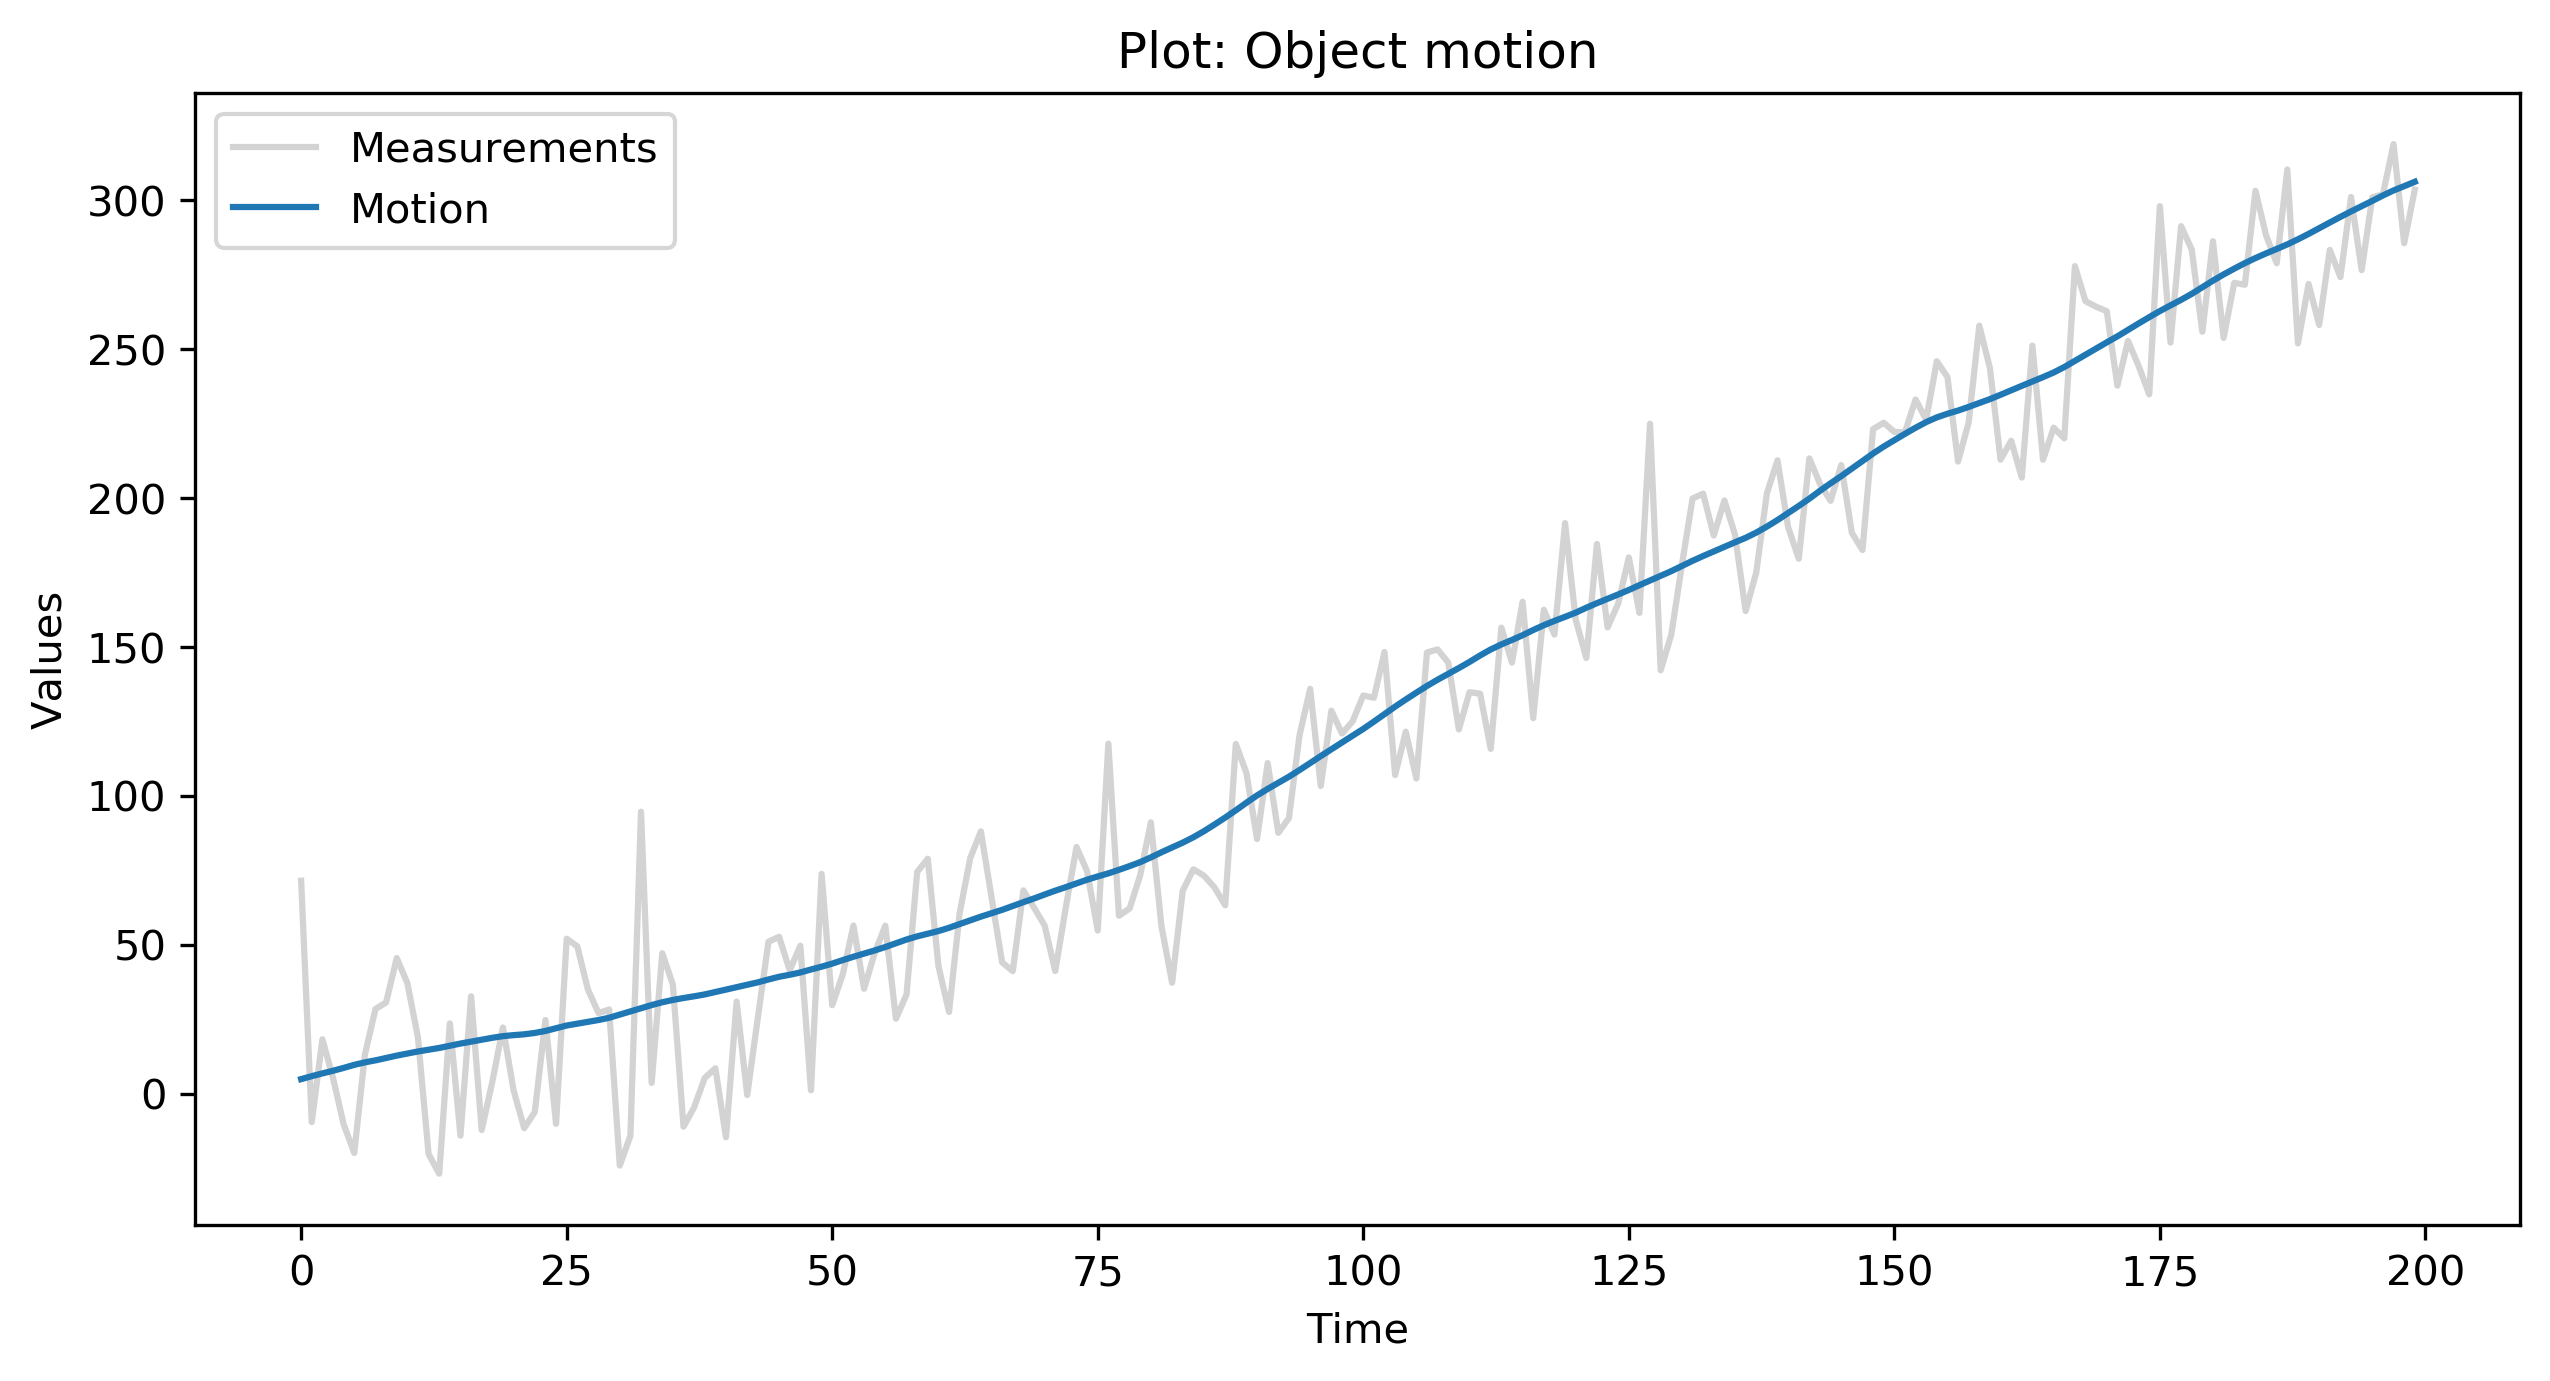

In [4]:
X1 = np.matrix((5,1))
F = np.matrix(((1,t),(0,1)))
G = np.matrix((t**2/2,t)).T
H = np.matrix((1,0))

X = np.zeros([c,2])
X[0] = X1
for i in range (1,c):
    frst = np.matmul(F,np.asmatrix(X[i-1]).T)
    scnd = G.dot(a[i-1])
    X[i] = np.add(frst,scnd).T
    
Z = np.zeros(c)
for i in range (c):
    Z[i] = H.dot(X[i])+n[i]

figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Object motion')
plt.plot(Z, label='Measurements',c='lightgrey')
plt.plot(X.T[0], label='Motion')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [5]:
#Developing Kalman Filter
X0 = np.matrix((2,0))
P00 = np.matrix(((10000,0),(0,10000)))

#Covariance matrix Q
Q = 0 #np.matmul(G,G.T)*s2a
R = s2n
I = np.matrix(((1,0),(0,1)))

#Kalman filtering
P = P00
X_f = np.zeros([c,2])
K_f = np.zeros([c,2])
K_f[0] = (1,1)
P_g = np.zeros(c)
X_f[0] = X0
for i in range (1,c):
    X_p = F.dot(np.asmatrix(X_f[i-1]).T)
    Pz = np.add(F.dot(P).dot(F.T),Q)
    frst = np.add(H.dot(Pz).dot(H.T),R)
    K = Pz.dot(H.T).dot(np.linalg.inv(frst))
    pre_scnd = np.subtract(Z[i],H.dot(X_p))
    scnd = K.dot(pre_scnd)
    P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
    X_f[i] = np.add(X_p,scnd).T
    K_f[i] = K.T
    P_g[i] = np.sqrt(P[0,0])

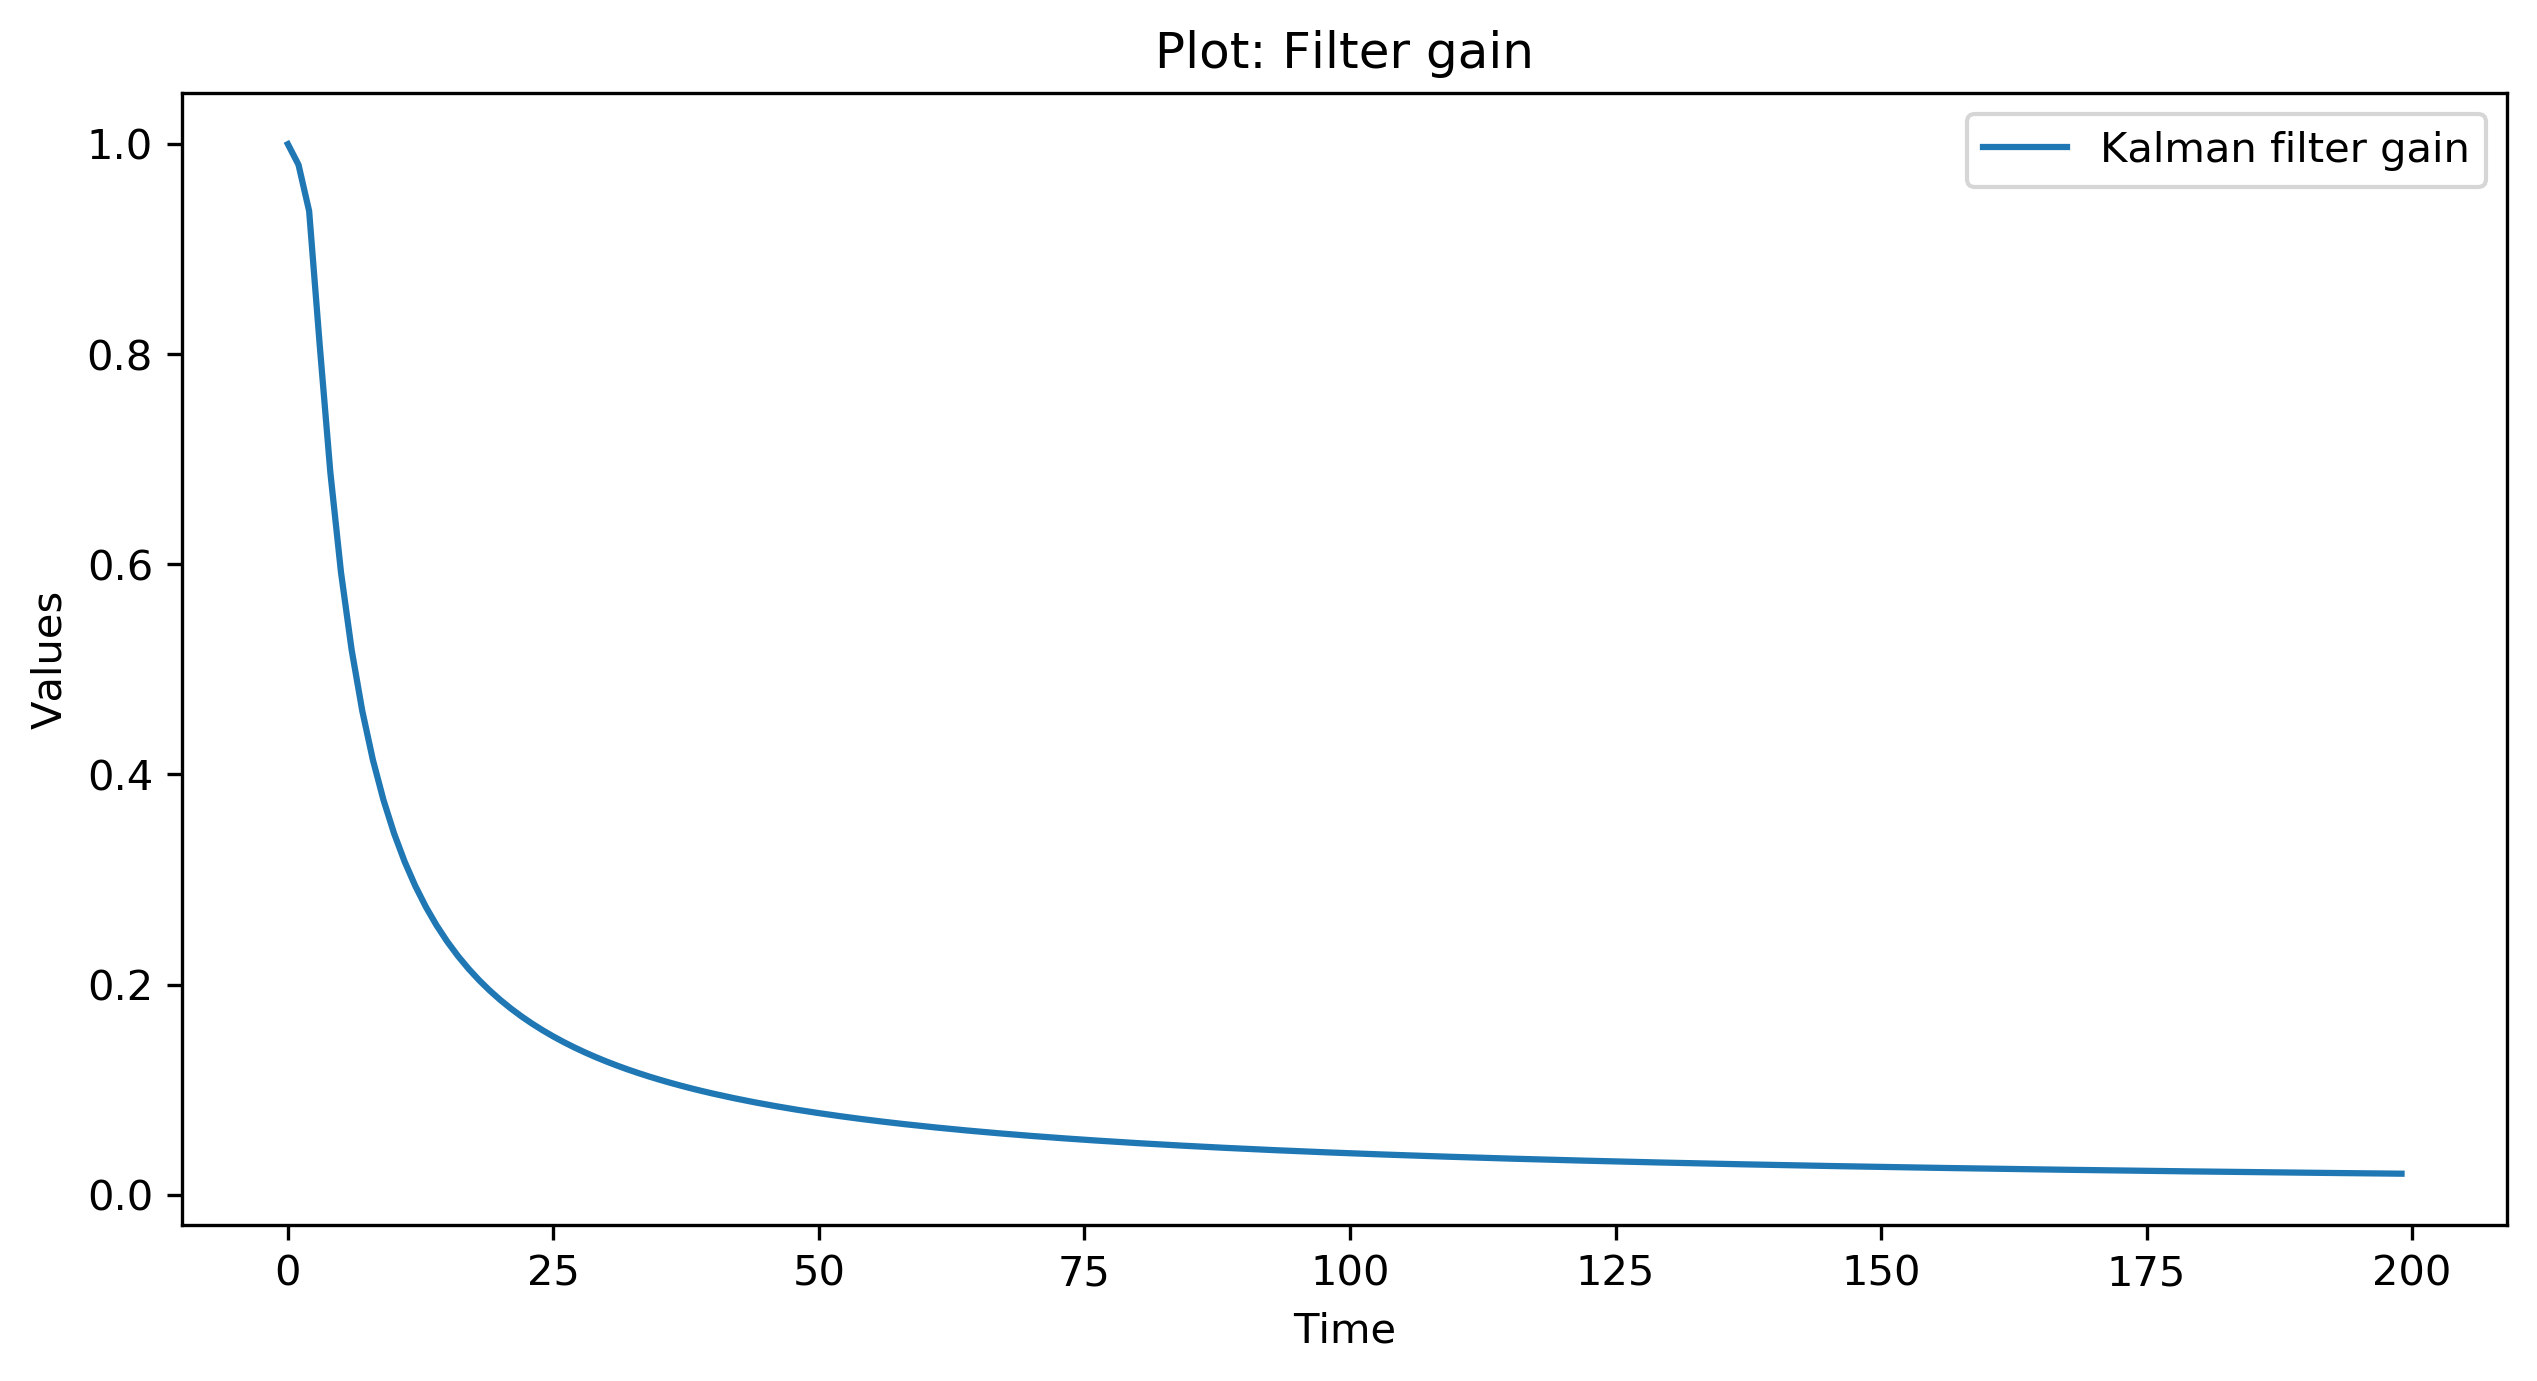

In [6]:
#6 Plot filter gain K
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Filter gain')    
plt.plot(K_f.T[0], label='Kalman filter gain')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [7]:
#Run 500 function
def run(n,seven=False, P_init=np.matrix(((10000,0),(0,10000))) ):
    def gen():
        a = np.random.normal(0,sa,c)
        n = np.random.normal(0,sn,c)
        X1 = np.matrix((5,1))
        F = np.matrix(((1,t),(0,1)))
        G = np.matrix((t**2/2,t)).T
        H = np.matrix((1,0))

        X = np.zeros([c,2])
        X[0] = X1
        for i in range (1,c):
            frst = np.matmul(F,np.asmatrix(X[i-1]).T)
            scnd = G.dot(a[i-1])
            X[i] = np.add(frst,scnd).T
        Z = np.zeros(c)
        for i in range (c):
            Z[i] = H.dot(X[i])+n[i]
        return X.T,Z
        
    def kalman(z_g):
        P = P_init
        X_f = np.zeros([c,2])
        X_f[0] = X0
        for i in range (1,c):
            X_p = F.dot(np.asmatrix(X_f[i-1]).T)
            Pz = np.add(F.dot(P).dot(F.T),Q)
            frst = np.add(H.dot(Pz).dot(H.T),R)
            K = Pz.dot(H.T).dot(np.linalg.inv(frst))
            pre_scnd = np.subtract(z_g[i],H.dot(X_p))
            scnd = K.dot(pre_scnd)
            P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
            X_f[i] = np.add(X_p,scnd).T
        return X_f.T
    def kalman7(z_g):
        P = P_init
        X_f7 = np.zeros([c,2])
        F7 = F
        for i in range (6):
            X_f7[i] = X_f.T[0][i]
            F7 = F7.dot(F)
        for i in range (6,c):
            X_p = F7.dot(np.asmatrix(X_f7[i-1]).T)
            Pz = np.add(F7.dot(P).dot(F7.T),Q)
            frst = np.add(H.dot(Pz).dot(H.T),R)
            K = Pz.dot(H.T).dot(np.linalg.inv(frst))
            pre_scnd = np.subtract(z_g[i],H.dot(X_p))
            scnd = K.dot(pre_scnd)
            P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
            X_f7[i] = np.add(X_p,scnd).T
        return X_f7.T

    error = np.zeros(c)
    for i in range (n):
        cur_x,cur_z = gen()
        if seven:
            prev = kalman(cur_z)
            res = kalman7(prev[0])
        else:
            res = kalman(cur_z)
        s = np.power(np.subtract(cur_x[0],res[0]),2)
        error = np.add(s,error)
    final = np.zeros(c)
    for k in range (2,c):
        final[k] = np.sqrt(error[k]/(n-1))
    return final

In [8]:
err_k = run(500)
err_k7 = run(500,True)

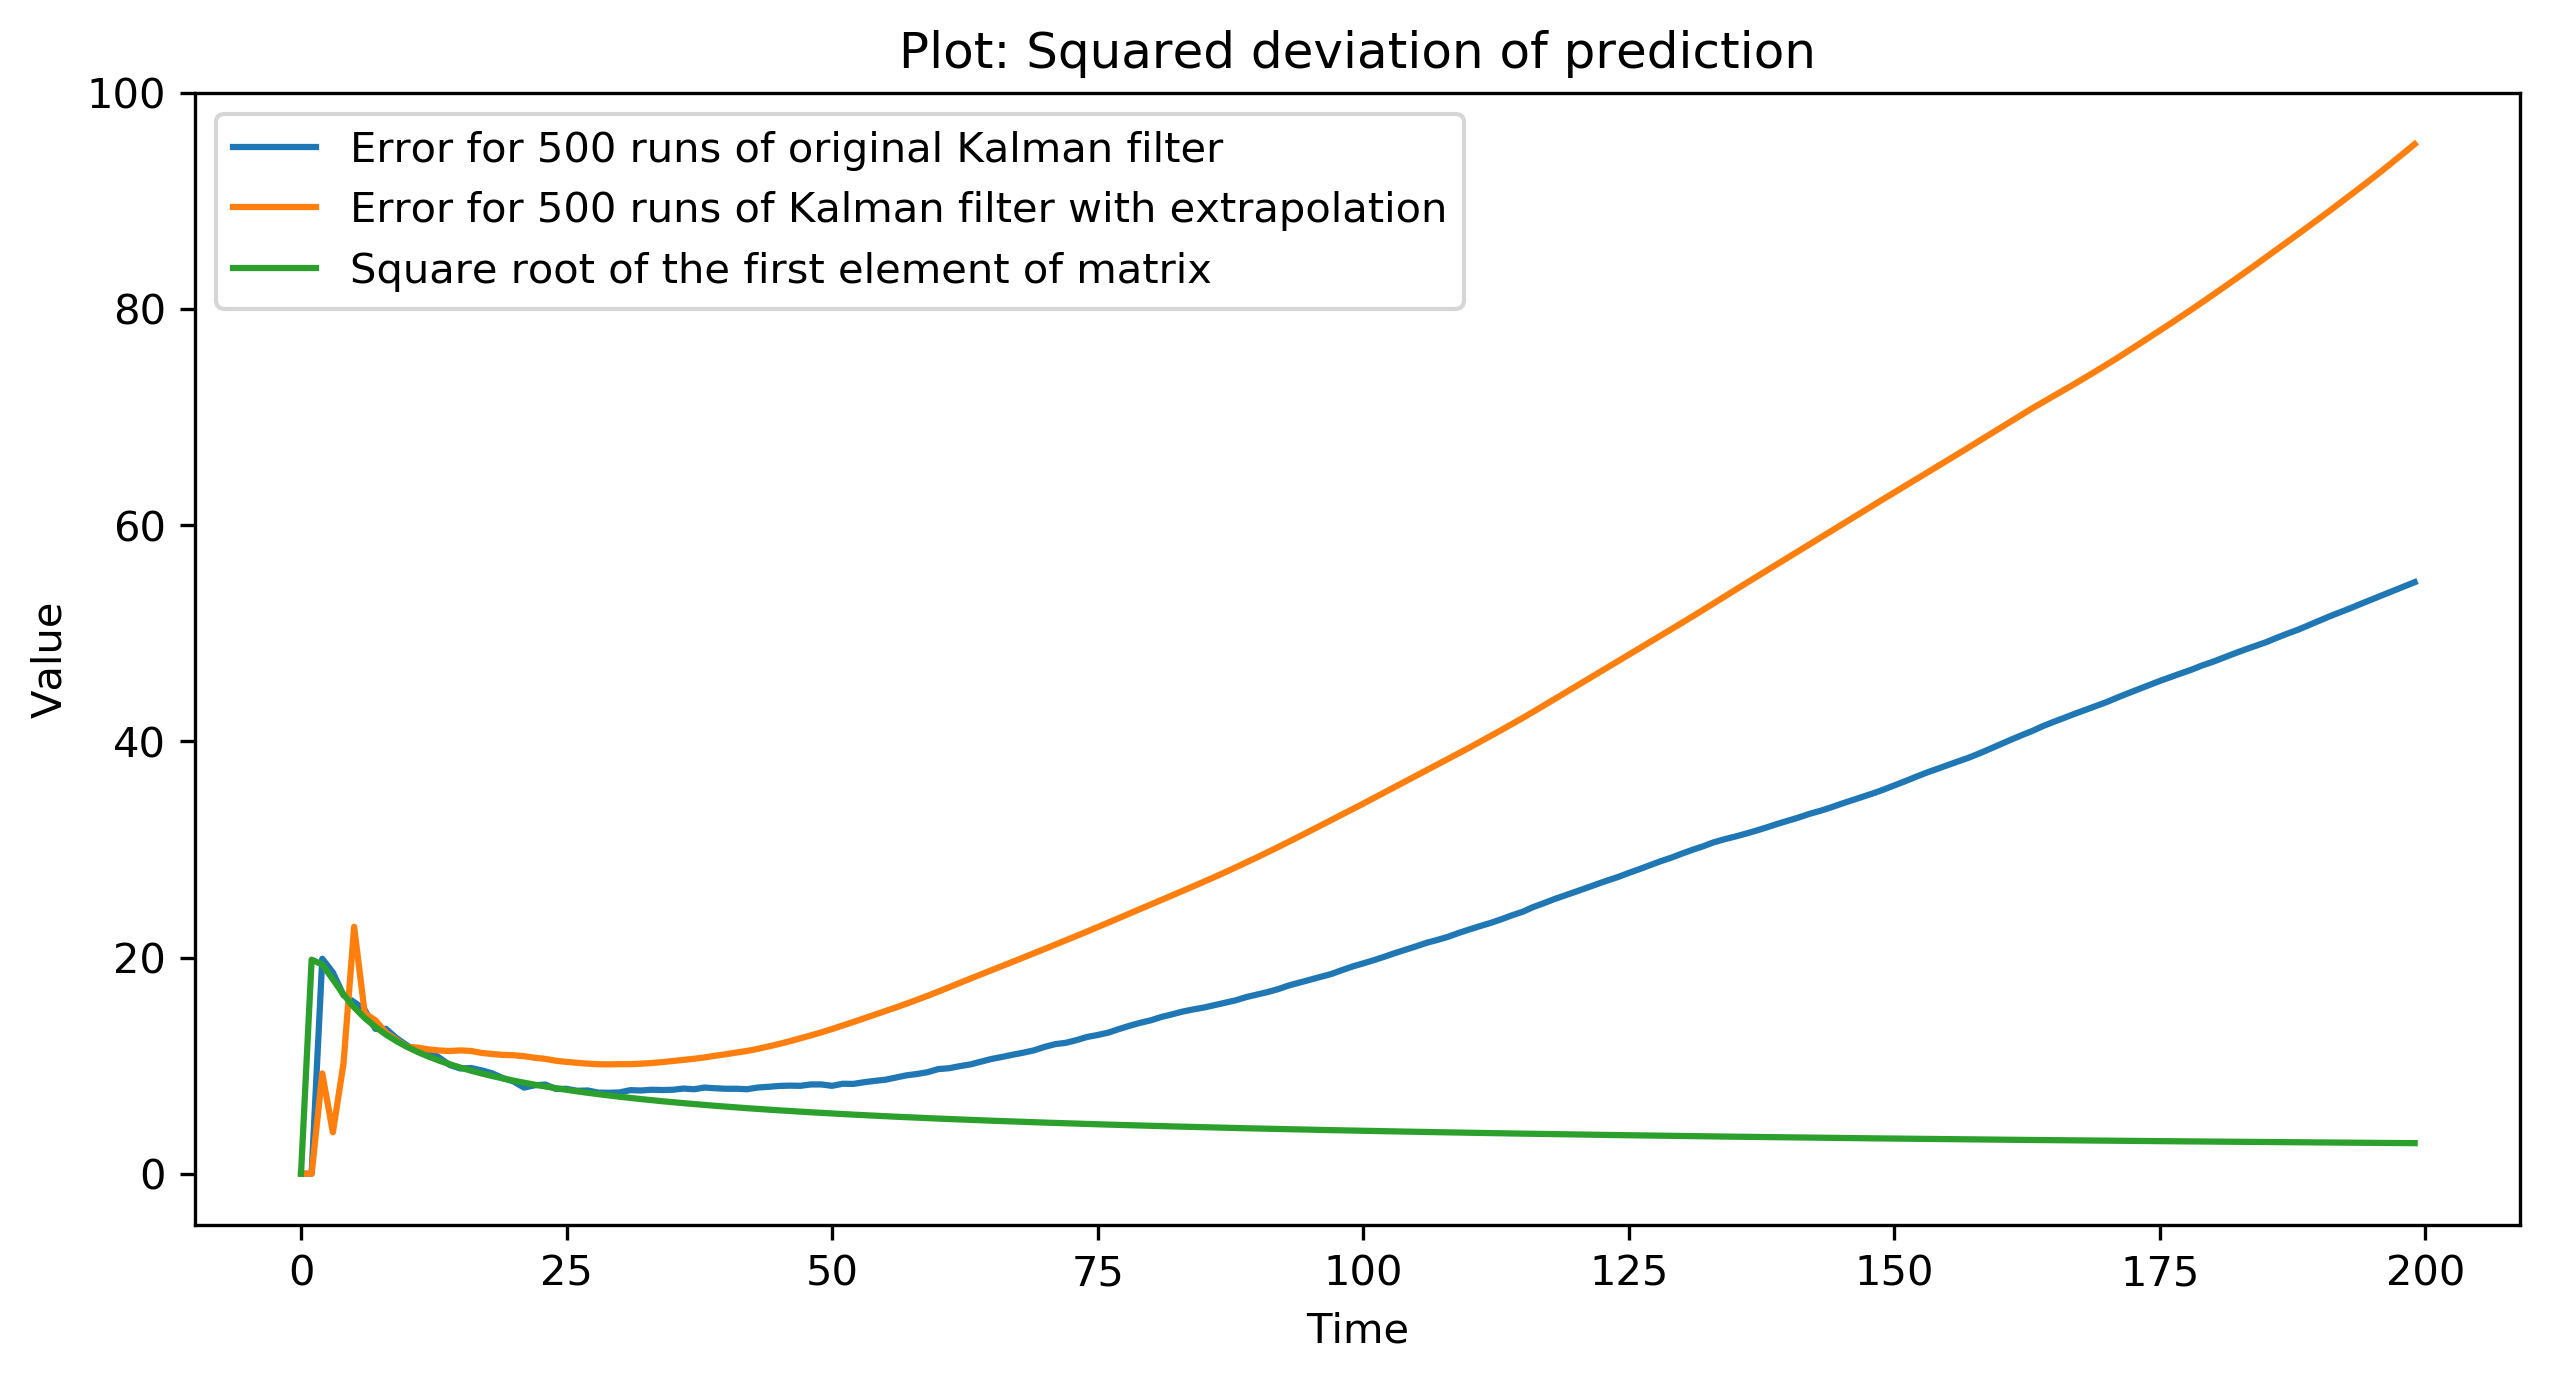

In [9]:
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Squared deviation of prediction')
plt.plot(err_k, label='Error for 500 runs of original Kalman filter')
plt.plot(err_k7, label='Error for 500 runs of Kalman filter with extrapolation')
plt.plot(P_g, label='Square root of the first element of matrix')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()